# NLP. Lesson 9. Knowledge graph

A knowledge graph (KG) is a structured representation of knowledge that consists of entities, relationships, and the connections between them. It is a powerful way of representing data because Knowledge Graphs can be built automatically and can then be explored to reveal new insights about the domain. It is often used to integrate, manage, and retrieve information in a more intuitive and human-like way. Knowledge graphs are powerful tools in the field of Natural Language Processing (NLP) for various applications such as information retrieval, question answering, semantic search, and more.

The concept of Knowledge Graphs borrows from the Graph Theory. In this particular representation, we store data as:
<img src="https://raw.githubusercontent.com/Dnau15/LabImages/main/images/lab09/KG.png" alt="KG" width="800"/>

Entity 1 and Entity 2 are called `nodes` and the Relationship is called an `edge`. Of course, in a real-world knowledge graph, there are lots of entities and relationships and there is more than one way to arrive at one entity starting from another.

Usually, these types of graphs is modeled with triples, which are sets of three items like (subject, verb, object), with the verb being the relationship between the subject and the object - for example (London, is_capital, England).

#### Integration with NLP Techniques
1. NER and Relation Extraction: use NLP techniques to extract entities and relationships from unstructured text.
2. Semantic Parsing: convert natural language queries into structured queries that can be executed on the knowledge graph.
3. Embedding Methods: represent entities and relationships as vectors in a continuous space to leverage machine learning models.

## Extraction of knowledge graph

In [1]:
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline

In [2]:
pipeline = spacy.load('en_core_web_sm')

In [3]:
!wget https://raw.githubusercontent.com/Dnau15/LabImages/main/data/txt_data/sentences.txt

--2024-07-04 09:50:11--  https://raw.githubusercontent.com/Dnau15/LabImages/main/data/txt_data/sentences.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47609 (46K) [text/plain]
Saving to: ‘sentences.txt’

sentences.txt       100%[===================>]  46.49K  --.-KB/s    in 0.001s  

2024-07-04 09:50:11 (31.2 MB/s) - ‘sentences.txt’ saved [47609/47609]



In [4]:
candidate_sentences = pd.read_csv("sentences.txt", delimiter='\t')
candidate_sentences.head()

,sentence
0,The quick brown fox jumps over the lazy dog.
1,Alice borrowed a book from Bob.
2,A purple pig flew a kite in the middle of the ...
3,Jenny gave a gift to Tom.
4,A song can make or ruin a person’s day.


### Extract entities

Revise the definitions from the dependency parsing. Consider the sentences: "She is eating the apple that she likes and two peaches quickly. The brown cat sleeps in the chair and twitches his tail."

- det: determiner (the)
- nsubj: nominal subject ('cat', 'she') - subject of a sentence
- ROOT: root ('sleeps') - the main verb of the sentence
- nummod: numeric modifier ('two') - numbers that modify a noun
- dobj: direct object ('apple') - direct object of a verb.
- punct: punctuation ('.') - punctuation marks
- amod: adjectival modifier ('brown') - connects an adjective to the noun
- advmod: adverbial modifier ('quickly') - connects an adverb to the word
- aux: auxiliary ('is') - connects an auxiliary verb to the main verb
- prep: prepositional modifier ('in') - connects a preposition to the word
- pobj: object of a preposition ('chair') - connects the object of a preposition to the preposition
- conj: conjunct (sleeps and 'twitches') - connects elements of a coordinated phrase
- cc: coordinating conjunction (apple 'and' peaches) - connects words or phrases of the same syntactic type
- ccomp: lausal complement ('that she likes') - connects a verb to its clausal complement
- mark: marker ('that') - connects a subordinate clause to the rest of the sentence

etc...

`Compound` is a condition that checks if the dependency label of the current token is "compound". This label indicates that the token is part of a compound noun. A compound noun is a noun that consists of more than one word, often working together as a single unit (e.g., "high school", "coffee cup").

In [5]:
example_doc = pipeline("She is eating the apple that she likes and two peaches quickly. \
                       The brown cat sleeps in the chair and twitches his tail.")
for tok in example_doc:
    print(tok.i, tok, ":", tok.dep_)

0 She : nsubj
1 is : aux
2 eating : ROOT
3 the : det
4 apple : dobj
5 that : dobj
6 she : nsubj
7 likes : relcl
8 and : cc
9 two : nummod
10 peaches : conj
11 quickly : advmod
12 . : punct
13                         : dep
14 The : det
15 brown : amod
16 cat : nsubj
17 sleeps : ROOT
18 in : prep
19 the : det
20 chair : pobj
21 and : cc
22 twitches : conj
23 his : poss
24 tail : dobj
25 . : punct


### Task 1.
Fill the gaps.

In [6]:
def get_entities(sentence: str) -> list:
    """ Function for extracting entities from the text.

    Args:
        sentence (str): string from which entities should be extractes

    Returns:
        entities (list): list of entities
    """

    prev_tok_dep = ""   # dependency tag of previous token in the sentence
    prev_tok_text = ""  # previous token in the sentence

    prefix = ""         # part of a compound word
    modifier = ""       # modifier in a compound word

    entity = ""
    entities = []

    # pass through all tokens
    for token in pipeline(sentence):

        # if token is a punctuation mark then move on to the next token
        if token.dep_ != ...:

            # if token is a compound word -> add it to the prefix of an entity
            if token.dep_ == "compound":
                prefix = token.text

                # if the previous word was also a 'compound' then add the current word to it
                if prev_tok_dep == "compound":
                    prefix = prev_tok_text + " " + token.text

            # check if token is a modifier
            if token.dep_.endswith("mod"):
                modifier = token.text

                # if the previous word was also a 'compound' then add the current word to it
                if prev_tok_dep == "compound":
                    modifier = prev_tok_text + " " + token.text

            # in case a token is a subject: combine prefix, modifier, and token, add it to entities
            if "subj" in token.dep_:
                ...

            # in case a token is an object: combine prefix, modifier, and token, add it to entities
            if "obj" in token.dep_:
                ...

            # update variables
            prev_tok_dep = ...
            prev_tok_text = ...

    return entities

In [7]:
ents = get_entities("the film had 200 patents. an apple lies on the table")
ents

['film', '200  patents', 'apple', 'table']

In [8]:
assert ents == ['film', '200  patents', 'apple', 'table']

Now we are supposed to extract entities from each sentence of our dataset. However, there might be problems in the further graph building. Why? Lets check what tricky sentences we have:

In [9]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 732/732 [00:07<00:00, 97.68it/s] 


In [10]:
print(entity_pairs[:5])

tricky_sentences = [ent for ent in entity_pairs if len(ent) < 2]
print('\n', tricky_sentences[:3])

[['brown  fox', 'lazy  dog'], ['Alice', 'book', 'Bob'], ['purple  pig', 'kite', 'middle', 'night'], ['Jenny', 'gift', 'Tom'], ['song', 'day']]

 [['lake'], ['This'], ['outside  house']]


In [11]:
candidate_sentences.iloc[[entity_pairs.index(['lake']), entity_pairs.index(['This'])], :]

,sentence
20,The lake is a long way from here.
21,This is a Japanese doll.


"The lake is far away from here" contains only 1 entity, thus a relation cannot be extracted in further. The relation is a connection between **2 entities**!

"This is a Japanese doll". "Japanese doll" seems to be an entity, however it's not (it's an attr - attribute). Read the [sources](https://downloads.cs.stanford.edu/nlp/software/dependencies_manual.pdf) and [discussion](https://stackoverflow.com/questions/62895997/nlp-what-is-exactly-a-grammar-dependence-tag-attr) on the StackOverflow for deeper understanding.

Since some sentences contain only 1 entity we will not be able to build relations. Lets get rid of tricky sentences in the dataset and update the entity_pairs variable:

In [12]:
# get indexes of those sentences
tricky_sentences = [i for i in range(len(entity_pairs)) if len(entity_pairs[i]) < 2]

In [13]:
candidate_sentences.drop(tricky_sentences, inplace=True, axis=0)
candidate_sentences.shape

(687, 1)

In [14]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
    entity_pairs.append(get_entities(i))

100%|██████████| 687/687 [00:06<00:00, 102.75it/s]


### Task 2. Extract relations
Build a function for extracting relations between them using the following grammar. For this task use class `Matcher` from spacy.matcher. Read the documentation [here](https://spacy.io/api/matcher)

In [15]:
grammar = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

In [16]:
from spacy.matcher import Matcher


def get_relation(sentence: str) -> str:
    """ Functoin for extracting relations

    Args:
        sentence (str): text from which relations should be extracted
    Returns:
        span.text (str): words which are relations
    """

    doc = pipeline(sentence)

    # Matcher class object
    matcher = ...

    #define the pattern
    pattern = grammar

    # add the pattern into matcher
    matcher.add(...)

    # match words from doc and the pattern
    matches = ...
    k = len(matches) - 1

    span = doc[matches[k][1]:matches[k][2]]

    return ...

In [17]:
get_relation("the film had 200 patents")

'had'

In [18]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 687/687 [00:06<00:00, 106.66it/s]


In [19]:
assert relations[1] == ('borrowed')

### Build knowledge graph


In [20]:
head = [i[0] for i in entity_pairs]
tail = [i[1] for i in entity_pairs]

knowledge_graph = pd.DataFrame({'head':head, 'tail':tail, 'relation':relations})
knowledge_graph.head()

,head,tail,relation
0,brown fox,lazy dog,jumps over
1,Alice,book,borrowed
2,purple pig,kite,flew
3,Jenny,gift,gave
4,song,day,make


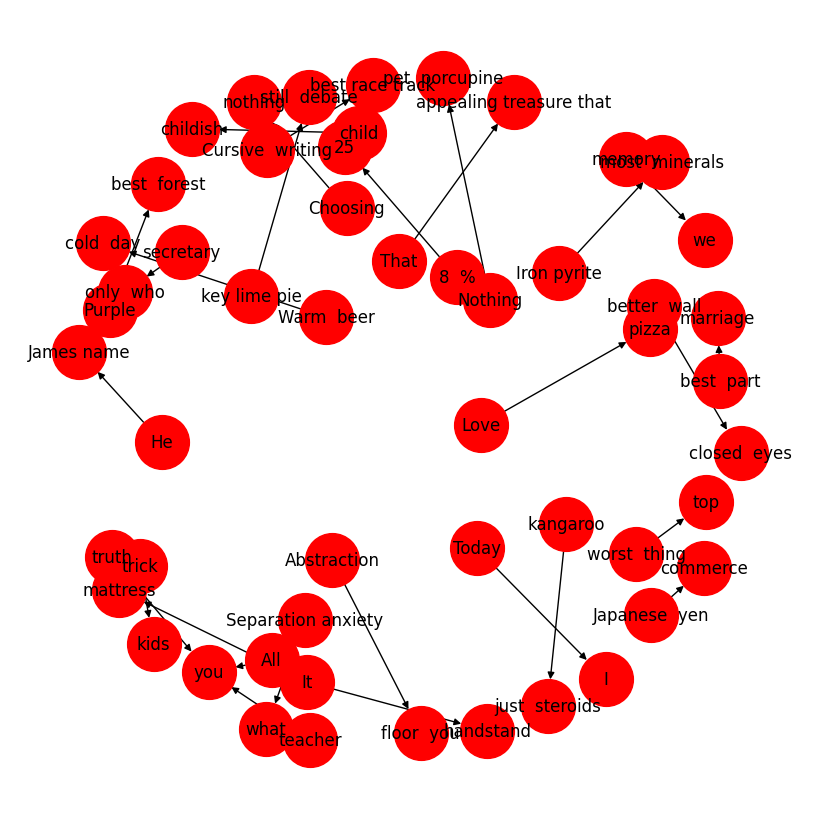

In [21]:
# Graph building
G = nx.from_pandas_edgelist(knowledge_graph[knowledge_graph['relation']=="is"], "head", "tail",
                            edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(8, 8))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='red', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

The applied approach is perfectly suitable for sentences with 2 entities and 1 relation between them. However there are sentences that cannot be processed using such a simple method. Assume the sentence: "I was starting to worry that my pet turtle could tell what I was thinking".

Entities: ['I', 'pet  turtle', 'what', 'I'].

Relation: 'starting'.

According to our model, the final graph for this sentence would be: I starting pet. 'To worry' would be omitted and the meaning of the sentence is lost. Thus, only small and simple pieces of text can be processed.

### Task 3.
Lets observe how the Matcher works, what it can do, and improve the get_relation function so that we could find **not only relations but entities too** using additional grammar. But instead of simple object definitions we will improve it with already found entitiy_pairs (read the functions' doc).

In [27]:
from spacy.matcher import Matcher

# Define patterns for relations and entities
relation_pattern = [
    {'DEP': 'ROOT'},
    {'DEP': 'prep', 'OP': "?"},
    {'DEP': 'agent', 'OP': "?"},
    {'POS': 'ADJ', 'OP': "?"}
]

subject_pattern = [{'DEP': 'nsubj'},
                   {'DEP': 'nsubjpass', 'OP':'?'}]

object_pattern = [{'DEP': 'pobj', 'OP': '?'},
                  {'DEP': 'dobj', 'OP': '?'}]

def get_relation_and_entities(sentence: str, entities: list):
    """ Function for extracting relations and entities

    Args:
        sentence (str): text from which relations and entities should be extracted
    Returns:
        Tuple: (subject, relation, object)
    """
    doc = pipeline(sentence)

    # Matcher class object
    matcher = ...

    # Add patterns to the matcher
    ...

    # Find matches in the sentence
    matches = ...

    subject = ""
    relation = ""
    object = ""
    all = []

    def match_entities(found: str) -> str:
        """ Function for matching found objects and subjects with entities from get_entities function.
        Assume Matcher found a subject 'cup'. But it is a compound word and 'coffe cup' must be an entity.
        The inner function match_entities takes a found word and tries to find something similar in the entities list.
        """
        ...

    for match_id, start, end in matches:
        span = doc[start:end]
        match_label = pipeline.vocab.strings[match_id]

        if match_label == "relation_pattern":
            relation = ...
        elif match_label == "subject_pattern":
            subject = ...
        elif match_label == "object_pattern":
            object = ...
        all.append((subject, relation, object))

    return all[-1]

sentence = 'the film had 200 patents'
all = get_relation_and_entities(sentence, ['film', '200 patents'])
print(all)


('film', 'had', '200 patents')


In [28]:
relations = [get_relation_and_entities(candidate_sentences.iloc[i, 0], entity_pairs[i]) for i in range(candidate_sentences.shape[0])]

In [29]:
assert relations[2] == ('purple pig', 'flew', 'night')

In [30]:
head = [i[0] for i in relations]
tail = [i[2] for i in relations]
relation = [i[1] for i in relations]

knowledge_graph = pd.DataFrame({'head':head, 'tail':tail, 'relation':relation})
knowledge_graph.head()

,head,tail,relation
0,brown fox,lazy dog,jumps over
1,Alice,Bob,borrowed
2,purple pig,night,flew
3,Jenny,Tom,gave
4,song,day,make


### Task 4.
Build 2 graphs. One graph is the same as in the previous application. And the second one: extract all entities that are related to each other through the word 'loves' and the optimal distance between nodes is 2. You can modify the picture size, what color the etities can be, etc.

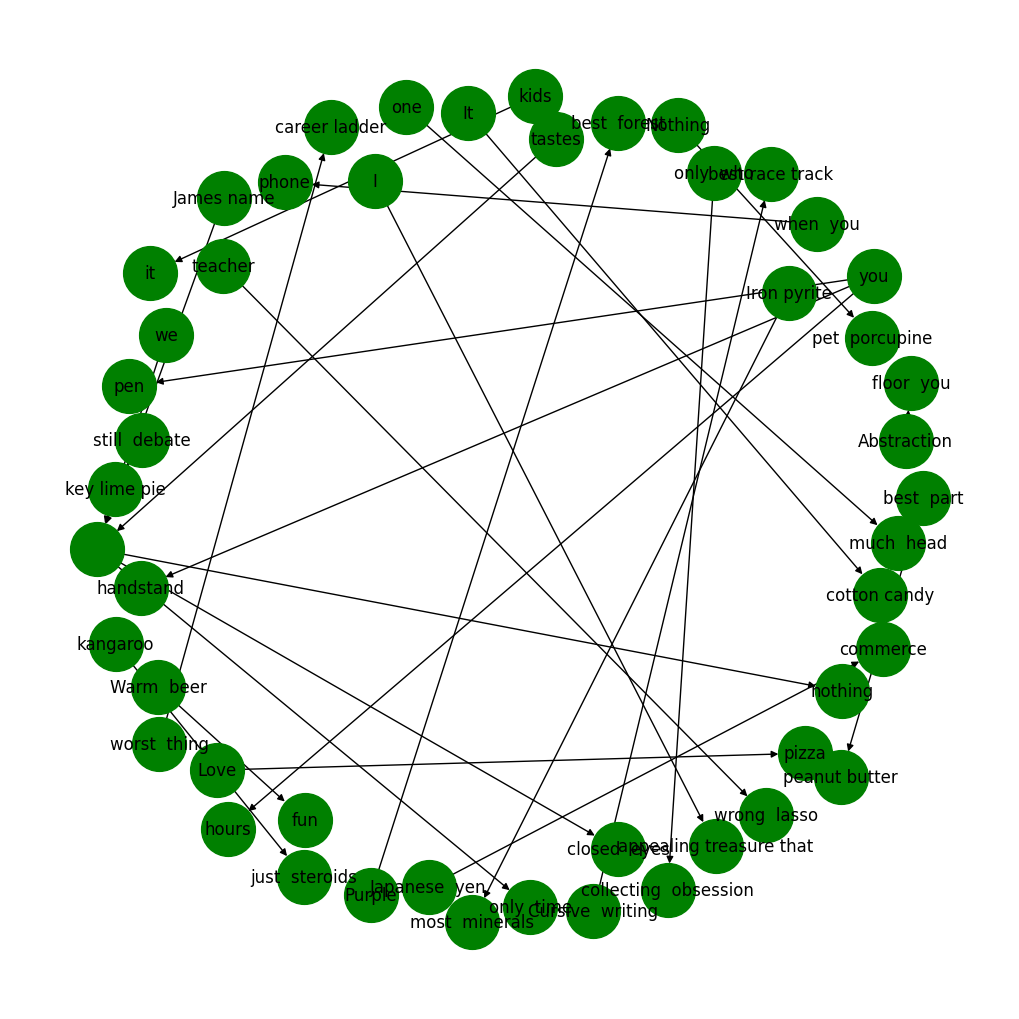

In [31]:
G = ...

plt.figure(figsize=(10, 10))
pos = ...
nx.draw(...)
plt.show()

In [32]:
assert len(G) == 49 and G.size() == 28
assert G.degree['It'] == 1
assert G.has_node('wrong  lasso')

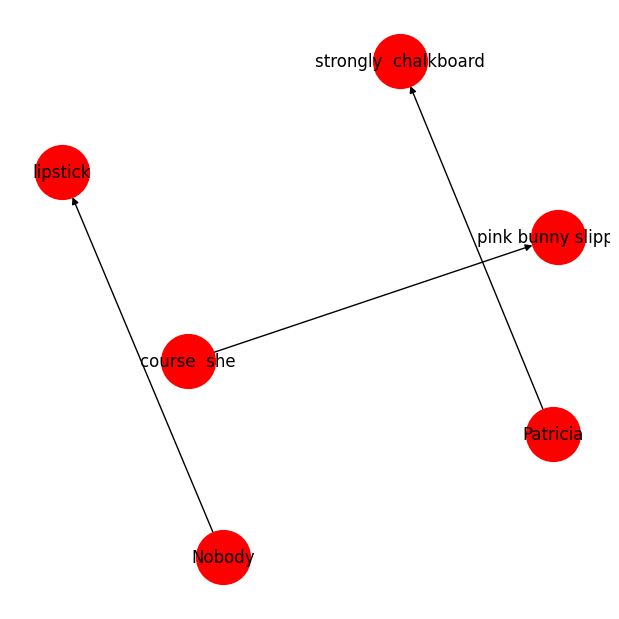

In [33]:
# Build a graph where all relations are 'loves', optimal distance between nodes is 2
G=...

plt.figure(figsize=(6, 6))
pos = ...
nx.draw(...)
plt.show()

In [34]:
assert len(G) == 6 and G.size() == 3
assert G.has_node('Nobody')

## Knowledge graph embeddings
Knowledge graph embedding (KGE) is a representation of a KG element into a continuous vector space. The objective of learning those embeddings is to ease the manipulation of graph elements (entities, relations) and capture the semantic meaning and relationships within the graph for prediction tasks such as entity classification, link prediction or recommender systems.

Embedding Space: knowledge graph embeddings map entities and relations into a continuous vector space where similar entities and relations are closer together.

Objective: The main objective is to preserve the structure and semantics of the knowledge graph within the embedding space, facilitating efficient computation and reasoning.

### PyKEEN (Python KnowlEdge EmbeddiNg)
PyKEEN is a Python package for reproducible, facile knowledge graph embeddings.

[PyKEEN docs](https://pykeen.readthedocs.io/en/stable/)


### Models
- [PairRE](https://arxiv.org/pdf/2011.03798.pdf) - model with paired vectors for each relation representation
- [TransE](https://proceedings.neurips.cc/paper_files/paper/2013/file/1cecc7a77928ca8133fa24680a88d2f9-Paper.pdf) - model that produces knowledge base embeddings. It models relationships by interpreting them as translations operating on the low-dimensional embeddings of the entities
- [ConvE](https://cdn.aaai.org/ojs/11573/11573-13-15101-1-2-20201228.pdf) - multi-layer convolutional network model for link prediction

More [examples](https://wasit7.medium.com/tutorial-knowledge-graph-embedding-with-pykeen-22d3b7847cea) of pykeen usage.

In the following blocks of code we perform knowledge graph embedding with the PairRE model on the "Nations" dataset - small and commonly used dataset in knowledge graph embedding research.

`Hits@5` is a commonly used evaluation metric in knowledge graph embedding. It measures the proportion of test triples for which the correct tail entity is ranked in the top 5 predictions.

In [2]:
%%capture
!pip install pykeen
!pip install seaborn

In [3]:
from pykeen.pipeline import pipeline
import matplotlib.pyplot as plt

INFO:pykeen.utils:Using opt_einsum


In [3]:
result = pipeline(
    dataset = "Nations",
    model = "PairRE",
    # Training configuration
    training_kwargs = dict(
        num_epochs = 10,
        use_tqdm_batch = False,
    ),
    # set the random state for reprodicibility
    random_seed = 0
)

INFO:pykeen.datasets.utils:Caching preprocessed dataset to file:///root/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=1592, path="/usr/local/lib/python3.10/dist-packages/pykeen/datasets/nations/train.txt") to file:///root/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.datasets.base:Stored training factory to file:///root/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/training
INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=14, num_relations=55, create_inverse_triples=False, num_triples=201, path="/usr/local/lib/python3.10/dist-packages/pykeen/datasets/nations/test.txt") to file:///root/.data/pykeen/datasets/nations/cache/47DEQpj8HBSa-_TImW-5JCeuQeRkm5NM/testing
INFO:pykeen.datasets.base:Stored testing factory to file:///root/.data/pykeen/datase

Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

Evaluating on cuda:0:   0%|          | 0.00/201 [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 0.23s seconds


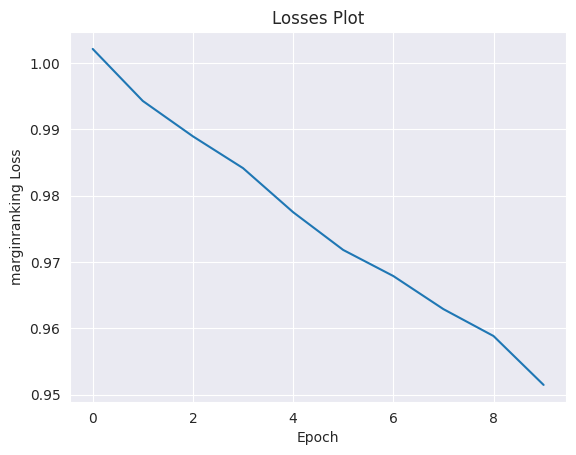

In [5]:
result.plot_losses()
plt.show()

In [6]:
print(f"Hits@5: {result.get_metric('hits@5')}")

Hits@5: 0.8905472636815921


This approach is useful for quickly setting up and testing different knowledge graph embedding models on standard datasets. By changing the model and dataset parameters, you can compare the performance of various models and datasets. The Hits@5 metric provides a quick insight into the model's predictive accuracy.

In [7]:
# Get entity embeddings
entity_embeddings = result.model.entity_representations[0]().cpu().detach().numpy()
entity_embeddings[:2]

array([[ 0.00476647,  0.06925077,  0.12553044, -0.01665277,  0.02682909,
        -0.03003703, -0.06081803,  0.10446753,  0.10319184,  0.1143557 ,
        -0.05973797, -0.07786074, -0.04297373, -0.05929245,  0.11220001,
        -0.11005784,  0.10251033, -0.04169615, -0.02349404,  0.04725758,
         0.04890217,  0.07949562, -0.06452501,  0.0601716 ,  0.06484478,
        -0.03220597,  0.08181567, -0.10310273,  0.0364957 , -0.07516918,
        -0.10936729, -0.10478182, -0.04719689,  0.04819778,  0.05761978,
        -0.07052857, -0.00715912, -0.01676507,  0.08660497, -0.12676296,
         0.07780733,  0.09102789,  0.02993574,  0.00490646, -0.08943526,
         0.08780359,  0.07652699, -0.07069918, -0.03908359, -0.10093224,
         0.02243898,  0.05186525,  0.06814041,  0.08207834,  0.08472954,
         0.10945476,  0.03730544, -0.09874314,  0.02192347,  0.09380221,
        -0.06383441,  0.09075955,  0.09779969, -0.07251527,  0.10602017,
         0.09619403,  0.04945054,  0.05916651,  0.0

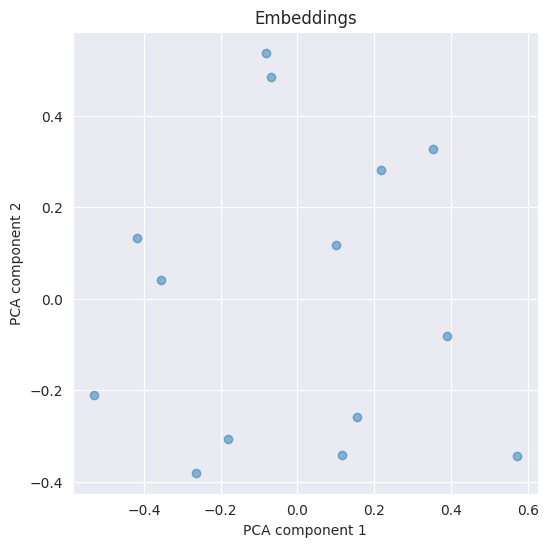

In [8]:
!pip install scikit-learn

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Use PCA to reduce dimensions to 2 for visualization on space
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(entity_embeddings)

# Plot the result
plt.figure(figsize=(6, 6))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], alpha=0.5)
plt.title('Embeddings')
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.show()

### Task 5.
As you know, there are multiple models that can be used in pykeen. Your task is to:
1. load the ['Kinship'](https://huggingface.co/datasets/VLyb/Kinship) dataset (a large-scale knowledge graph derived from Wikipedia, WordNet, and GeoNames)
2. train 2 different KGE models (TransE ([usage example](https://medium.com/stanford-cs224w/knowledge-graph-embeddings-simplistic-and-powerful-representations-ed43a1a73c7c)) and [DistMult](https://medium.com/stanford-cs224w/introducing-distmult-and-complex-for-pytorch-geometric-6f40974223d0)). Choose the appropriate amount of epochs
3. evaluate the trained models using standard metrics like [Hits@10, Mean Rank, or Mean Reciprocal Rank (MRR)](https://www.evidentlyai.com/ranking-metrics/evaluating-recommender-systems)
4. compare he performance of the models
5. Visualize the entity embeddings using dimensionality reduction techniques: [PCA or t-SNE](https://habr.com/ru/companies/otus/articles/757030/)

Plug the CUDA and train the models using GPU, because CPU takes a lot of time. Also, you can use Google.Colab or Kaggle.

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cuda


In [9]:
from pykeen.pipeline import pipeline
import pandas as pd

# Define a function to train and evaluate 2 models
def train_and_evaluate_model(model_name, dataset, epochs, device):
    result = pipeline(
        dataset = dataset,
        model = model_name,
        training_kwargs = dict(
            num_epochs = epochs,
            use_tqdm_batch = True,
        ),
        random_seed = 42,
        device = device
    )
    return result

In [ ]:
data = ...
transE = ...
distMult = ...

# Train TransE model
transE_result = train_and_evaluate_model(transE, data, epochs=..., device=device)

# Train DistMult model
distMult_result = train_and_evaluate_model(distMult, data, epochs=..., device=device)

In [19]:
print(f"TransE Hits@10: {transE_result.get_metric('hits@10')}")
print(f"TransE Mean Rank: {transE_result.get_metric('mean_rank')}")
print(f"TransE Mean Reciprocal Rank: {transE_result.get_metric('mean_reciprocal_rank')}")

print(f"DistMult Hits@10: {distMult_result.get_metric('hits@10')}")
print(f"DistMult Mean Rank: {distMult_result.get_metric('mean_rank')}")
print(f"DistMult Mean Reciprocal Rank: {distMult_result.get_metric('mean_reciprocal_rank')}")

TransE Hits@10: 0.22253258845437615
TransE Mean Rank: 34.505584716796875
TransE Mean Reciprocal Rank: 0.08058006316423416
DistMult Hits@10: 0.729050279329609
DistMult Mean Rank: 7.799813747406006
DistMult Mean Reciprocal Rank: 0.3098725974559784


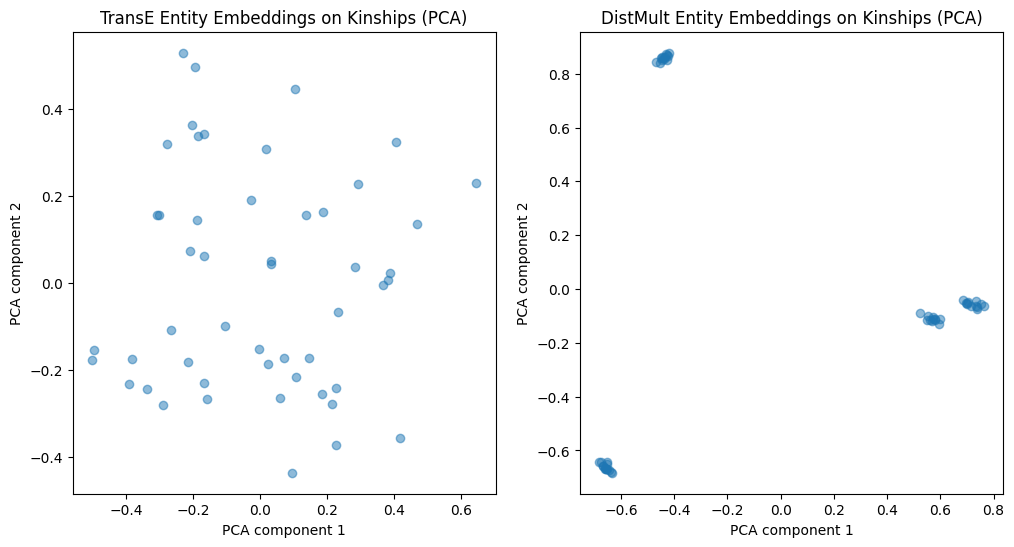

In [14]:
from sklearn.decomposition import PCA

def visualize_embeddings(result, model_name, dataset_name, i):
    # Get entity embeddings for the first 50 values
    entity_embeddings = ...

    # Use t-SNE or PCA to reduce dimensions to 2 for visualization
    pca = ...
    reduced_embeddings = ...

    # Plot the embeddings
    ax[i].scatter(..., alpha=0.5)
    ax[i].set_title(f'{model_name} Entity Embeddings on {dataset_name}')
    ax[i].set_xlabel('Component 1')
    ax[i].set_ylabel('Component 2')
    return pca

_, ax = plt.subplots(1, 2, figsize=(12, 6))

# visualize embeddings for 2 models, set i=0 and i=1
...

plt.show()

In [15]:
assert data == 'Kinships'
assert transE == 'TransE'
assert distMult == 'DistMult'
assert transE_result.configuration['model'] == 'TransE'
assert distMult_result.configuration['model'] == 'DistMult'
assert transE_result.get_metric('mean_reciprocal_rank') >= 0.08
assert distMult_result.get_metric('mean_reciprocal_rank') >= 0.3
assert distMult_result.get_metric('hits@10') >= 0.7

# Conclusion

This lesson provided a hands-on exploration of building a knowledge graph (KG). We covered the theoretical foundation of knowledge graphs, then dove into practical techniques using spaCy and Matcher for entity and relation extraction from text data.

- Theoretical foundations: we established the core concepts of KGs, understanding their role in representing real-world entities and relationships.
- Entity extraction with spaCy: hands-on practice with spaCy allowed us to extract key entities from text data, forming the building blocks of our KG.
- Relation extraction with Matcher: we explored Matcher's capabilities for identifying relationships between entities, enriching the structure of our KG.
- KG construction with "Nations" dataset: utilizing the "Nations" dataset, we constructed a practical KG, demonstrating the process of populating it with entities and relations.
- KG embeddings with pyKeen: we learned how pyKeen can be used to create KG embeddings, a powerful method for representing KGs numerically for further analysis and tasks like link prediction.